<a href="https://colab.research.google.com/github/Abhaykum123/Damped_Harmoic_Oscillator/blob/main/PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://substackcdn.com/image/fetch/$s_!AfDZ!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fbd5b6423-3621-4125-b8b1-88d22ce48909_540x613.gif" width="400" height="500">


## Fully Connected Neural Network(FCNN)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Helper to save GIF
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True,
                 duration=int(1000/fps), loop=loop)

In [ ]:
# Oscillatory function
def oscillator(d, w0, x):
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1 / (2 * np.cos(phi))
    cos = tf.math.cos(phi + w * x)
    exp = tf.math.exp(-d * x)
    y = exp * 2 * A * cos
    return y

In [ ]:
# Generate data
d, w0 = 2, 20
x = tf.linspace(0.0, 1.0, 500)
x = tf.reshape(x, (-1, 1))
y = oscillator(d, w0, x)

In [ ]:
x_data = tf.gather(x, tf.range(0, 200, 20))
y_data = tf.gather(y, tf.range(0, 200, 20))

In [ ]:
# Plotting
def plot_result(x, y, x_data, y_data, yh, xp=None, step=None, fname=None):
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x, yh, color="blue", linewidth=4, alpha=0.8, label="Prediction")
    plt.scatter(x_data, y_data, s=60, color="red", alpha=0.8, label="Training data")
    if xp is not None:
        plt.scatter(xp, -0 * xp, s=60, color="green", alpha=0.4, label="Physics points")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    if step is not None:
        plt.text(1.065, 0.7, f"Step: {step}", fontsize="xx-large", color="k")
    plt.axis("off")
    plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    if fname:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        plt.close()

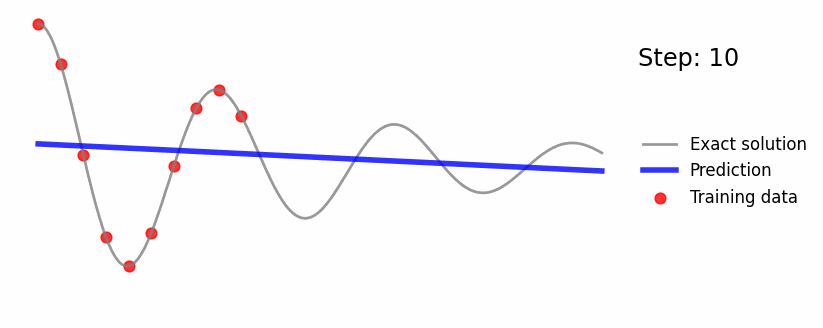

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/nn.gif'))

## Physics-Informed Neural Network (PINN)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# Fully Connected Network
def build_fcn(n_input, n_output, n_hidden, n_layers):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(n_input,)))
    model.add(layers.Dense(n_hidden, activation='tanh'))
    for _ in range(n_layers - 1):
        model.add(layers.Dense(n_hidden, activation='tanh'))
    model.add(layers.Dense(n_output))
    return model

In [ ]:
model = build_fcn(1, 1, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)blob:https://colab.research.google.com/09ac5716-80fa-4bdd-9634-e3b39224b32b

In [ ]:
os.makedirs("plots", exist_ok=True)
files = []
for i in range(1000):
    with tf.GradientTape() as tape:
        yh = model(x_data, training=True)
        loss = tf.reduce_mean(tf.square(yh - y_data))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if (i+1) % 10 == 0:
        yh_pred = model(x, training=False)
        fname = f"plots/nn_{i+1:08d}.png"
        plot_result(x.numpy(), y.numpy(), x_data.numpy(), y_data.numpy(),
                    yh_pred.numpy(), step=i+1, fname=fname)
        files.append(fname)

save_gif_PIL("nn.gif", files, fps=20, loop=0)

In [ ]:
# from IPython.display import Image
# Image(filename="nn.gif")

In [ ]:
x_physics = tf.linspace(0.0, 1.0, 30)
x_physics = tf.reshape(x_physics, (-1, 1))
mu, k = 2 * d, w0 ** 2

In [ ]:
model = build_fcn(1, 1, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
files = []

In [ ]:
for i in range(20000):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_physics)
        yh_data = model(x_data, training=True)
        loss1 = tf.reduce_mean(tf.square(yh_data - y_data))

        yhp = model(x_physics, training=True)
        dx = tape.gradient(yhp, x_physics)
        dx2 = tape.gradient(dx, x_physics)
        residual = dx2 + mu * dx + k * yhp
        loss2 = 1e-4 * tf.reduce_mean(tf.square(residual))

        loss = loss1 + loss2

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    del tape

    if (i+1) % 150 == 0:
        yh_pred = model(x, training=False)
        fname = f"plots/pinn_{i+1:08d}.png"
        plot_result(x.numpy(), y.numpy(), x_data.numpy(), y_data.numpy(),
                    yh_pred.numpy(), x_physics.numpy(), step=i+1, fname=fname)
        files.append(fname)

save_gif_PIL("pinn.gif", files, fps=20, loop=0)

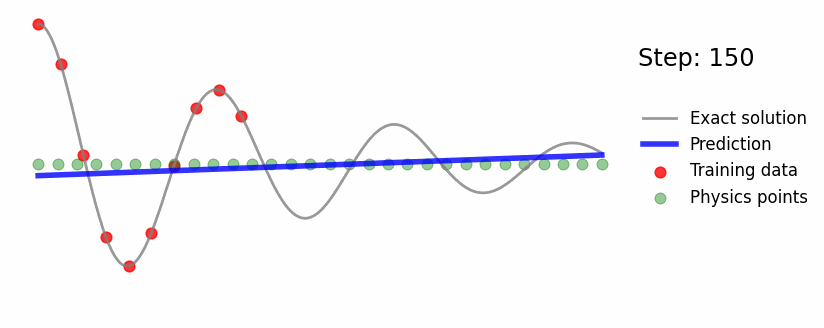

In [ ]:
Image(filename="pinn.gif")